# Geospatial Analysis Workflow



### Load libraries and data 

In [2]:
# Load relevant R packages
inLibraries = list('repr','rgeos','rgdal','spdep','gstat','classInt','geoR','GISTools','sp','raster')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"no DISPLAY variable so Tk is not available"

## Vehicle Crash Data

In this project, I'm working with vehicle crash data for the state of Indiana. The dataset (indianacrashes/Dec2013Crashes.shp) is a point featureclass representing crash locations reported in December 2013. The dataset (indianacrashes/INRoads) is a line featureclass representing HPMS (https://www.fhwa.dot.gov/policyinformation/hpms/fieldmanual/HPMS_2014.pdf) road data.

In this project, the goal is to analyze vehicle crashes.  Vehicle crashes can be analyzed at the individual or point level,  at the road or line level, or at an area level/polygon analysis area which will be the focus of this notebook. 


## DATA PROCESSING

The first set of tasks is related to data preparation.

Let's read in the crash locations and road features. Also, read in the transportation analysis zones (indianacrashes/INTAZ.shp) which could be helpful in subsetting the data later on. 

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "Dec2013Crashes"
with 12283 features
It has 28 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "INTAZ"
with 6218 features
It has 12 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "INRoads"
with 21270 features
It has 70 fields


Warning message in readOGR("/dsa/data/geospatial/DS8612/indianacrashes", "INRoads"):
"Z-dimension discarded"

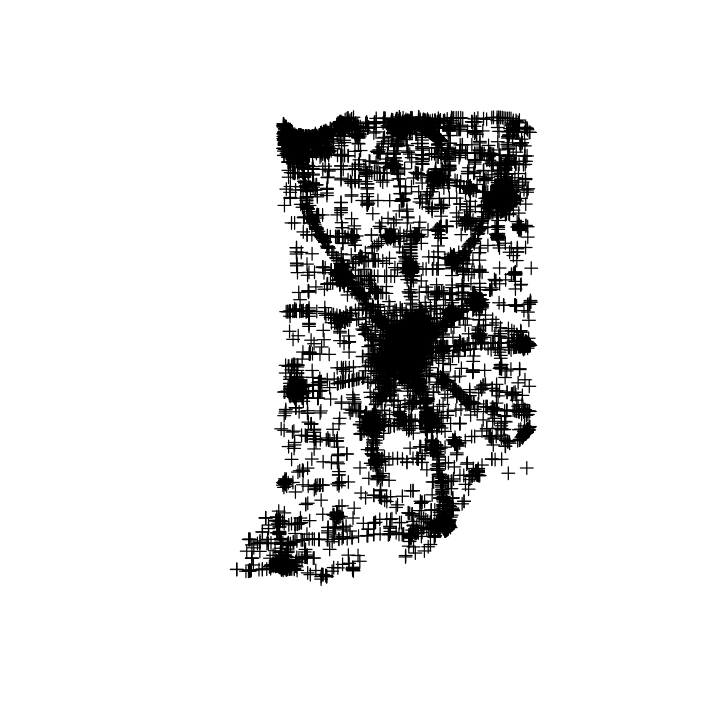

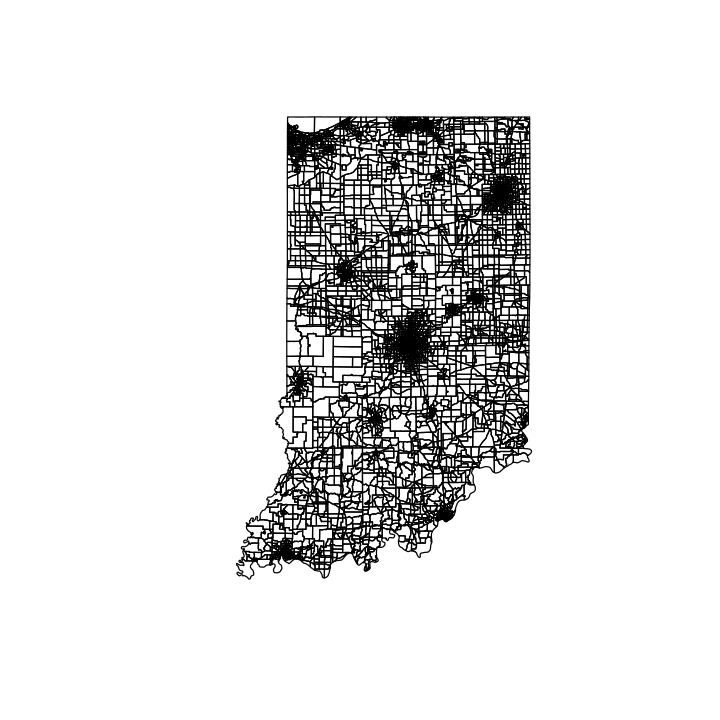

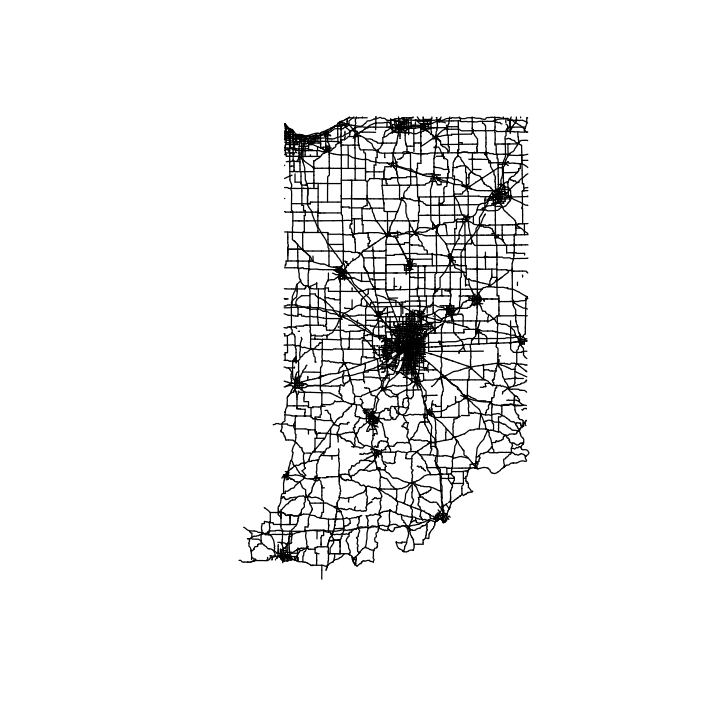

In [3]:
# crashes
Vdata <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes","Dec2013Crashes")

#read in the tract polygons
inTAZ <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes","INTAZ")

#read in the roads shapefile
inRoads <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes","INRoads")

#shapes <- list(Vdata, inTAZ, inRoads)
plot(Vdata)
#plot(inShape)
plot(inTAZ)
plot(inRoads)

Select a region appropriate CRS with measurement units in meters. 

In [4]:
shapes <- list(Vdata, inTAZ, inRoads)
lapply(shapes, proj4string)

[[1]]
[1] "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

[[2]]
[1] "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

[[3]]
[1] "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"


# Find projections specific to Indiand


[1] "+init=epsg:26916 +proj=utm +zone=16 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

[1] "+init=epsg:26916 +proj=utm +zone=16 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

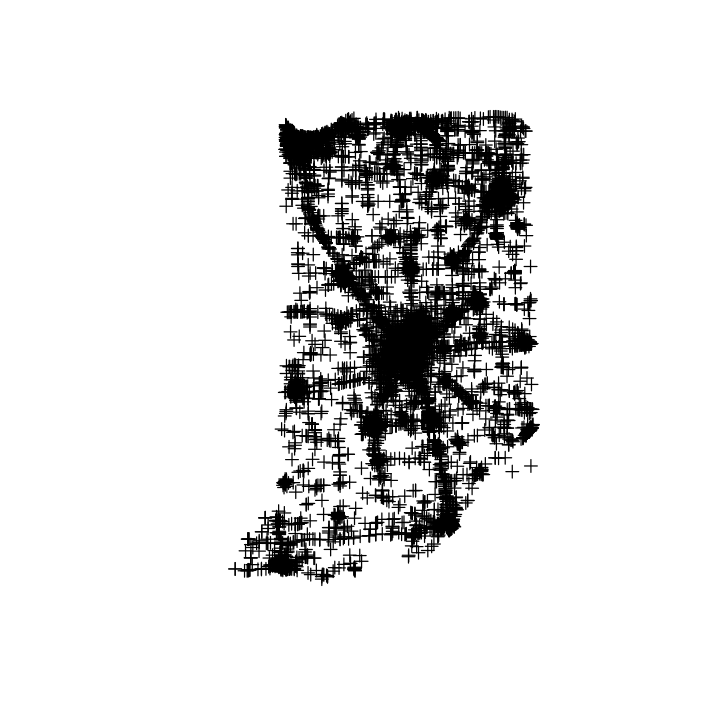

In [5]:
# Transform to angular system (lat/long)
inTAZ <- spTransform(inTAZ, CRS("+init=epsg:26916"))
inRoads <- spTransform(inRoads, CRS("+init=epsg:26916"))
Vdata<- spTransform(Vdata, CRS("+init=epsg:26916"))

#Take a look at the new coordinate system to verify
proj4string (inTAZ)
proj4string (Vdata)
plot(Vdata)

[1] 12283

[1] 6844

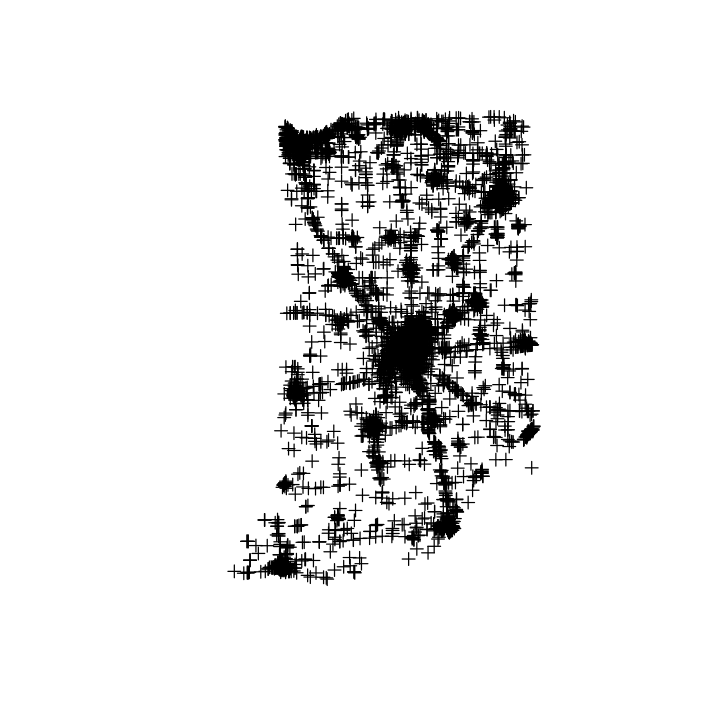

In [6]:
# Take samples from the crash file 

length(Vdata)

numsamples <- 6000
#get features in dataset
dl <- length(Vdata)

# Draw samples randomly
samp.rand <- Vdata[sample(dl,numsamples),]

# Select sampled points 
Vsample <- Vdata[samp.rand,]

length(Vsample)
plot(Vsample)

Now we'll write some code that checks for a field named 'road.id' (in the road dataset) and one named 'crash.id' (in the crash dataset) and one named 'LENGTHMETER' (in both datasets).  If the .id field is present (in the road and crash data), set the values to be an unique integer index for each feature. If the .id field is not present,we will add the field and assign each feature an unique id.  If the 'LENGTHMETER' field is not present, I will add it and set the value for each feature to be the length of the feature in meters.  

In [7]:
# Your code for Task 4 goes here.

Vsample@data$uniqueid <- seq.int(nrow(Vsample@data))
inTAZ@data$uniqueid <- seq.int(nrow(inTAZ@data))
inRoads@data$uniqueid <- seq.int(nrow(inRoads@data))

Vsample@data$LENGTHMETER <- gLength(Vsample, byid=TRUE)
inTAZ@data$LENGTHMETER <- gLength(inTAZ, byid=TRUE)
inRoads@data$LENGTHMETER <- gLength(inRoads, byid=TRUE)

str(Vsample@data)
str(inTAZ@data)
str(inRoads@data)



'data.frame':	6844 obs. of  30 variables:
 $ COUNTYCDE  : int  1 151 177 29 29 161 3 177 47 29 ...
 $ TOWNSHIPCD : int  65862 68454 81944 42480 42480 77678 37836 81944 84068 42480 ...
 $ CITYCDE    : int  17074 1666 64260 42462 29448 43434 52992 64260 11044 42462 ...
 $ COLLDTE    : Factor w/ 31 levels "20131201","20131202",..: 8 5 21 3 6 11 12 10 11 21 ...
 $ COLLDAYWEE : int  1 5 7 3 6 4 5 3 4 7 ...
 $ COLLTIMETX : Factor w/ 720 levels "0100","0101",..: 414 321 166 240 303 377 404 441 259 712 ...
 $ COLLTIMEAM : Factor w/ 2 levels "A","P": 2 1 2 2 2 1 2 1 2 2 ...
 $ COLLTIMEMI : Factor w/ 1395 levels "0000","0001",..: 1153 341 906 980 1043 397 1144 461 999 732 ...
 $ MOTORVEHIN : int  1 1 2 2 1 1 1 1 2 2 ...
 $ INJUREDNMB : int  0 0 0 0 0 0 0 0 1 0 ...
 $ DEADNMB    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DEERNMB    : int  0 1 0 0 0 0 1 0 0 0 ...
 $ PROPDAMAGE : int  3 3 2 3 3 3 3 3 3 3 ...
 $ RDWYCLASSC : int  2 2 5 2 5 4 5 1 2 2 ...
 $ AGGRESSIVE : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1

Now I will select crash sites that are within 50m of a road segment. 

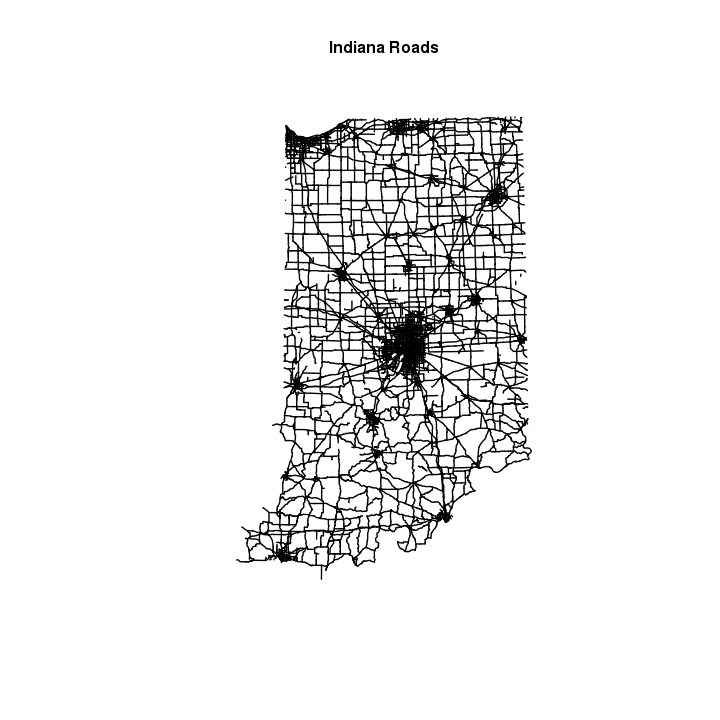

In [8]:
#road.buff <- gBuffer(inRoads, width = 50)
road.buff <- gBuffer(inRoads, byid=TRUE, id=NULL, width=50, quadsegs=5, capStyle="ROUND", joinStyle="ROUND", mitreLimit=1.0)
plot(inRoads, col="red", pch=21, lwd=.2,cex=0.5,main='Indiana Roads',cex.main=.8)
plot(road.buff, add=TRUE, col="grey")


Now I will aggregate the crash locations within 50m of a road to the appropriate road segment such as to determine the number of crashes per road segment.  I will then compute the number of crashes per mile in a new column named "crash.frq" in the road dataset.

[1] "list"

[1] "There are  6254  crashes within 50 meters of the roads"


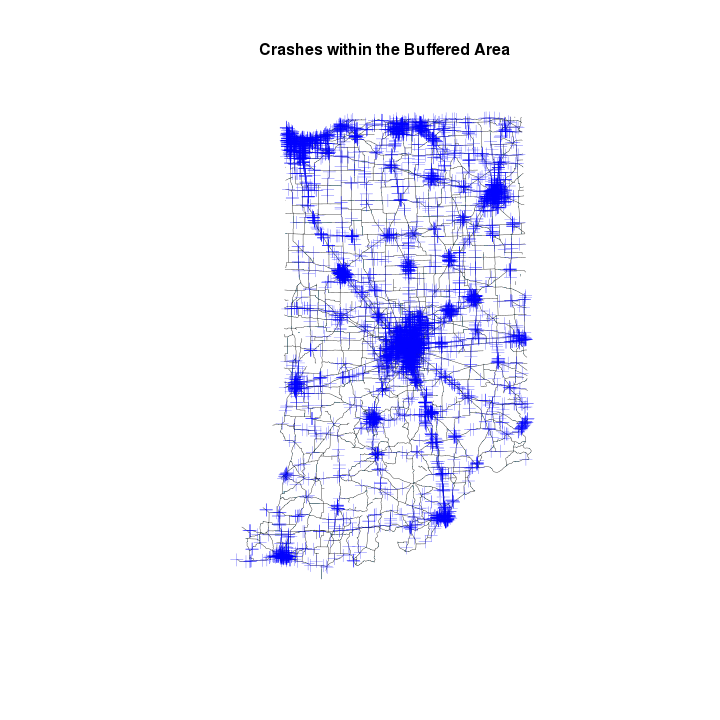

In [9]:
road_union <- gUnaryUnion(road.buff)
selFeat <- overGeomGeom(road_union, Vsample, returnList = TRUE, fn = NULL)

#determine type of output obtained from over()
typeof(selFeat)

#unlist the list
intSet = unlist(selFeat)

#determine number of intersecting features
print(paste("There are ",length(intSet)," crashes within 50 meters of the roads"))

#Select the intersecting features from the featureclass
intFeat <- Vsample[intSet,]

#Display selected features
plot(road_union,col="lightblue",lwd=.2,main='Crashes within the Buffered Area',cex.main=.8)
plot(intFeat,col="blue",lwd=.2,add=TRUE)
#plot(FeatA, add=TRUE, col="red",lwd=.2)
#plot(silo_buff,add=TRUE,lwd=1)

intFeat@data$NumCrashes <- 1

Now I will generate 3 polygon analysis areas covering the state of Indiana. I will increase the cell size at intervals. 

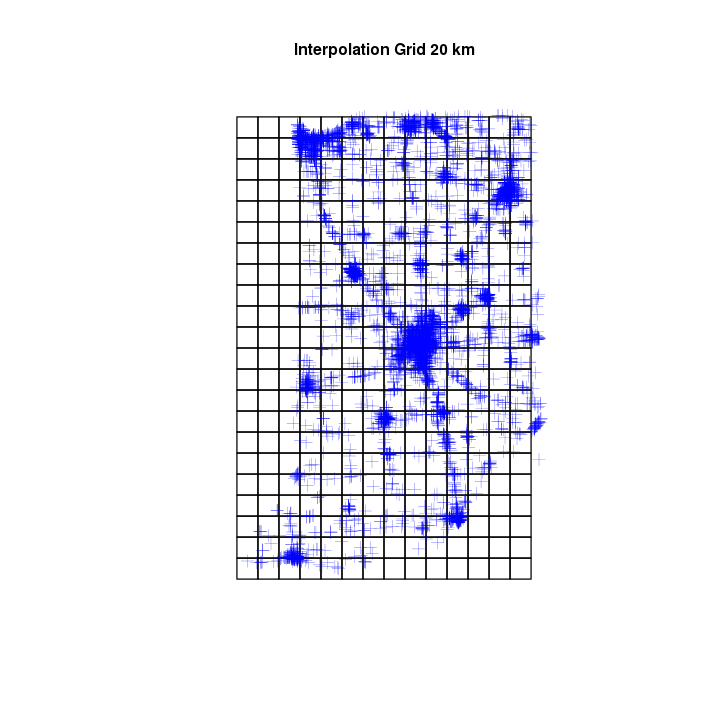

In [10]:
# create a grid object using extent of study site, lower value of cell size gives better resolution but higher computation time
grd <- expand.grid(Longitude = seq(from = min (coordinates(intFeat)[,1]), to = max (coordinates(intFeat)[,1]), by = 20000),
                   Latitude = seq(from = min (coordinates(intFeat)[,2]),to = max (coordinates(intFeat)[,2]), by = 20000))

# specify the coordination system of grid object to be that of original dataset
coordinates(grd) <- ~ Longitude + Latitude

# creat a fishnet of grid object accordingly
gridded(grd) <- TRUE

# set the projection system to be that of original dataset
proj4string(grd)=proj4string(Vsample)

# inRoads@data$uniqueid <- seq.int(nrow(inRoads@data))
# Vsample@data$LENGTHMETER <- gLength(Vsample, byid=TRUE)
#grd2<-SpatialGrid(grid=grd, proj4string = CRS("+init=epsg:32632 +proj=utm +zone=32 +ellps=intl +units=m +no_defs")) 

#spix <- as(grd2, "SpatialPixels") 
spol <- as(grd, "SpatialPolygons") 
spdf <- SpatialPolygonsDataFrame(spol, data=data.frame(id=seq.int(row.names(spol)), 
   row.names=row.names(spol))) 

plot(spdf,main="Interpolation Grid 20 km",cex.main=.8)
plot(intFeat,col="blue",lwd=.2,add=TRUE)             

In [11]:
spdf@data$id # check your ID column

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
[163] 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
[181] 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
[199] 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
[217] 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
[235] 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
[253] 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
[271] 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
[289] 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
[307] 307 308

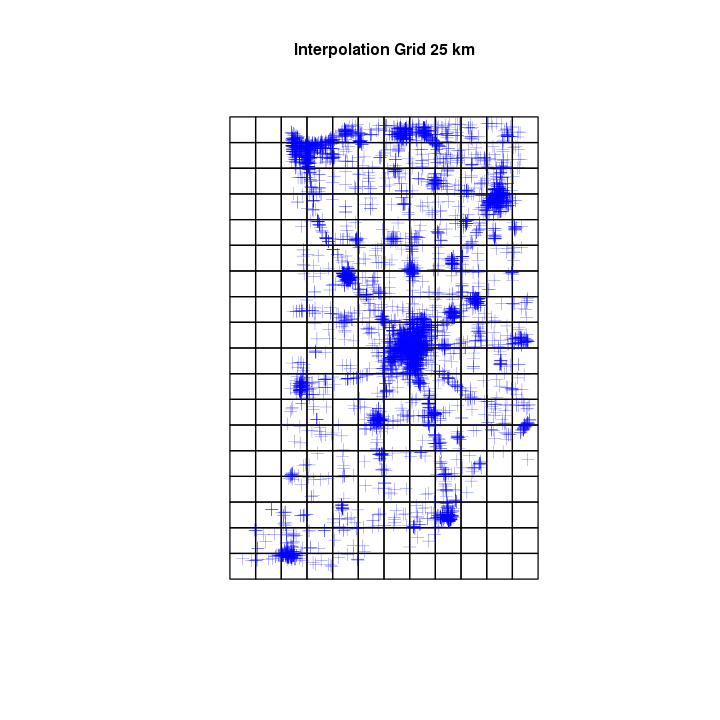

In [12]:
# create a grid object using extent of study site, lower value of cell size gives better resolution but higher computation time
grd <- expand.grid(Longitude = seq(from = min (coordinates(intFeat)[,1]), to = max (coordinates(intFeat)[,1]), by = 25000),
                   Latitude = seq(from = min (coordinates(intFeat)[,2]),to = max (coordinates(intFeat)[,2]), by = 25000))

# specify the coordination system of grid object to be that of original dataset
coordinates(grd) <- ~ Longitude + Latitude

# creat a fishnet of grid object accordingly
gridded(grd) <- TRUE

# set the projection system to be that of original dataset
proj4string(grd)=proj4string(Vsample)

# inRoads@data$uniqueid <- seq.int(nrow(inRoads@data))
# Vsample@data$LENGTHMETER <- gLength(Vsample, byid=TRUE)
#grd2<-SpatialGrid(grid=grd, proj4string = CRS("+init=epsg:32632 +proj=utm +zone=32 +ellps=intl +units=m +no_defs")) 

#spix <- as(grd2, "SpatialPixels") 
spol <- as(grd, "SpatialPolygons") 
spdf2 <- SpatialPolygonsDataFrame(spol, data=data.frame(id=seq.int(row.names(spol)), 
   row.names=row.names(spol))) 

plot(spdf2,main="Interpolation Grid 25 km",cex.main=.8)
plot(intFeat,col="blue",lwd=.2,add=TRUE)  

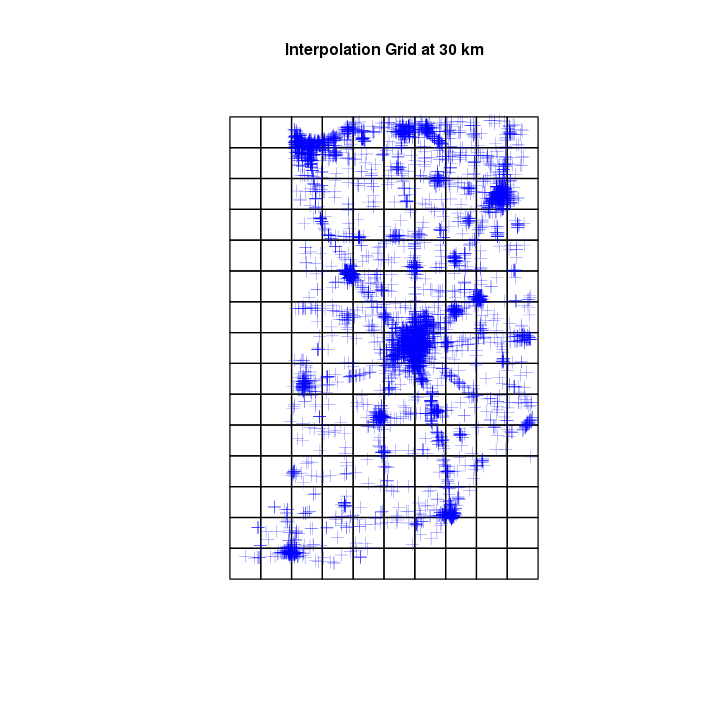

In [13]:
# create a grid object using extent of study site, lower value of cell size gives better resolution but higher computation time
grd <- expand.grid(Longitude = seq(from = min (coordinates(intFeat)[,1]), to = max (coordinates(intFeat)[,1]), by = 30000),
                   Latitude = seq(from = min (coordinates(intFeat)[,2]),to = max (coordinates(intFeat)[,2]), by = 30000))

# specify the coordination system of grid object to be that of original dataset
coordinates(grd) <- ~ Longitude + Latitude

# creat a fishnet of grid object accordingly
gridded(grd) <- TRUE

# set the projection system to be that of original dataset
proj4string(grd)=proj4string(Vsample)

# inRoads@data$uniqueid <- seq.int(nrow(inRoads@data))
# Vsample@data$LENGTHMETER <- gLength(Vsample, byid=TRUE)
#grd2<-SpatialGrid(grid=grd, proj4string = CRS("+init=epsg:32632 +proj=utm +zone=32 +ellps=intl +units=m +no_defs")) 

#spix <- as(grd2, "SpatialPixels") 
spol <- as(grd, "SpatialPolygons") 
spdf3 <- SpatialPolygonsDataFrame(spol, data=data.frame(id=seq.int(row.names(spol)), 
   row.names=row.names(spol))) 

plot(spdf3,main="Interpolation Grid at 30 km",cex.main=.8)
plot(intFeat,col="blue",lwd=.2,add=TRUE)  

In [14]:
str(spdf@data$id)

 int [1:308] 1 2 3 4 5 6 7 8 9 10 ...


Let's iterate over the set of 3 analysis areas generated in the previous task and map them. 

NULL


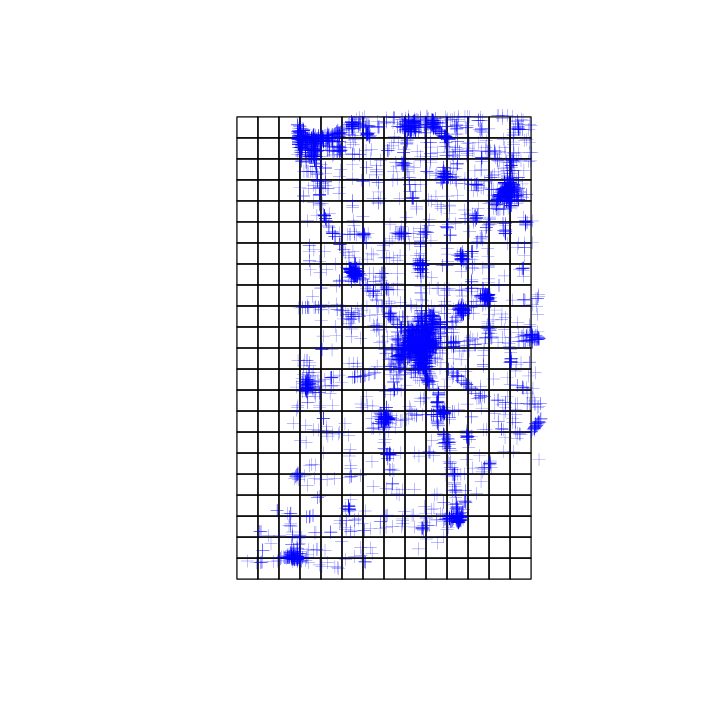

NULL


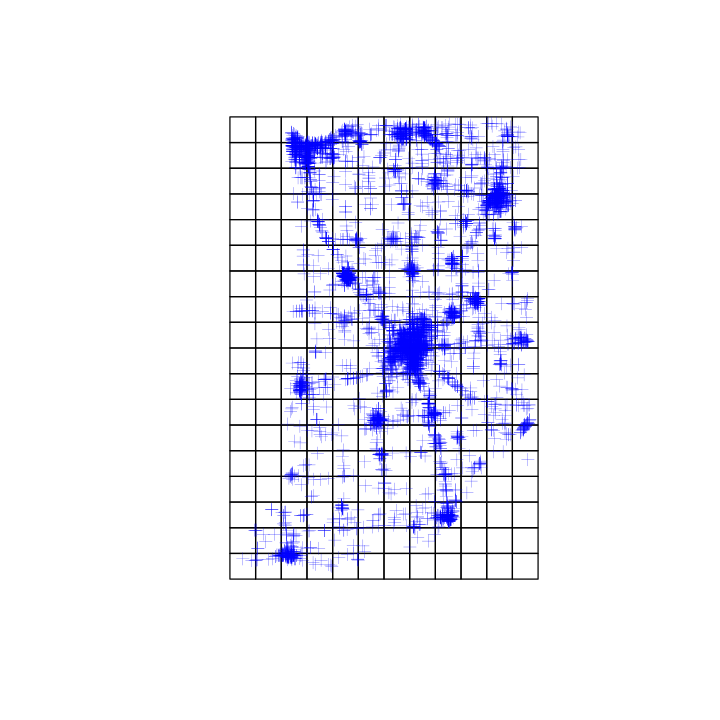

NULL


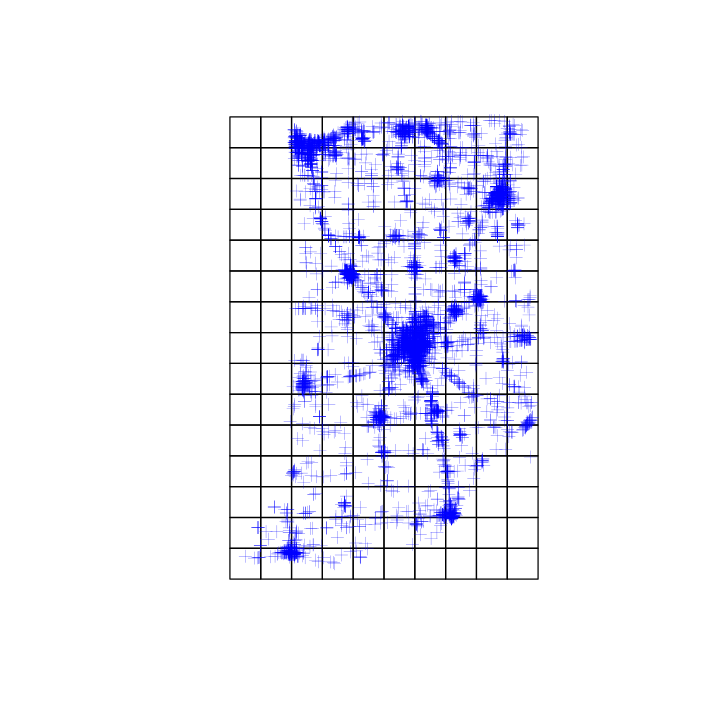

In [15]:
library(gridExtra)
plotlist <- list(spdf, spdf2, spdf3)
# lapply(plotlist, plot)

for (i in plotlist) {
    x <- plot(i)
    print(x)
    plot(intFeat,col="blue",lwd=.2,add=TRUE)  
    }

Let's computes the number of crashes within each analysis polygon stored in a new column named "crash.frq". 

In [16]:
plotlist <- list(spdf, spdf2, spdf3)

grid_crash <- over(intFeat,spdf) 
grid2_crash <- over(intFeat, spdf2)
grid3_crash <- over(intFeat, spdf3)

In [17]:
grid_crash <- over(intFeat,spdf) 

#configure new variables  str(spdf3@data$id)
intFeat@data$utrackid <- grid_crash$id
#intFeat@data$NumCrashes <- 1

head(intFeat@data,n=3)

retainedvariables <- c("NumCrashes","utrackid")
polyevents <- intFeat@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf@data$NumCrashes <- ordered$NumCrashes

COUNTYCDE TOWNSHIPCD CITYCDE COLLDTE  COLLDAYWEE COLLTIMETX COLLTIMEAM
1   1       65862      17074   20131208 1          0753       P         
5 151       68454       1666   20131205 5          0620       A         
8  29       42480      42462   20131203 3          0459       P         
  COLLTIMEMI MOTORVEHIN INJUREDNMB <U+22EF>   RDWYCHARCD SURFACETYP PRIMARYFAC
1 1953       1          0          <U+22EF> 1          2          56        
5 0620       1          0          <U+22EF> 1          1          64        
8 1659       2          0          <U+22EF> 1          1          13        
  DAMAGEESTI MANNERCOLL lat      uniqueid LENGTHMETER NumCrashes utrackid
1 3          6          40.84790 1        0           1          252     
5 3          7          41.63125 2        0           1          308     
8 3          1          39.09620 4        0           1           NA

In [18]:
# code for the second grid 25 km

#configure new variables  str(spdf3@data$id)
intFeat@data$utrackid <- grid2_crash$id
#intFeat@data$NumCrashes <- 1

head(intFeat@data,n=3)

retainedvariables <- c("NumCrashes","utrackid")
polyevents <- intFeat@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf2@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf2@data$NumCrashes <- ordered$NumCrashes
head(spdf2@data$NumCrashes)

COUNTYCDE TOWNSHIPCD CITYCDE COLLDTE  COLLDAYWEE COLLTIMETX COLLTIMEAM
1   1       65862      17074   20131208 1          0753       P         
5 151       68454       1666   20131205 5          0620       A         
8  29       42480      42462   20131203 3          0459       P         
  COLLTIMEMI MOTORVEHIN INJUREDNMB <U+22EF>   RDWYCHARCD SURFACETYP PRIMARYFAC
1 1953       1          0          <U+22EF> 1          2          56        
5 0620       1          0          <U+22EF> 1          1          64        
8 1659       2          0          <U+22EF> 1          1          13        
  DAMAGEESTI MANNERCOLL lat      uniqueid LENGTHMETER NumCrashes utrackid
1 3          6          40.84790 1        0           1          168     
5 3          7          41.63125 2        0           1          215     
8 3          1          39.09620 4        0           1           72

[1]   3  15 119   6   7   0

In [19]:
# code for the third grid 30 km

#configure new variables  str(spdf3@data$id)
intFeat@data$utrackid <- grid3_crash$id
#intFeat@data$NumCrashes <- 1

head(intFeat@data,n=3)

retainedvariables <- c("NumCrashes","utrackid")
polyevents <- intFeat@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf3@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf3@data$NumCrashes <- ordered$NumCrashes

COUNTYCDE TOWNSHIPCD CITYCDE COLLDTE  COLLDAYWEE COLLTIMETX COLLTIMEAM
1   1       65862      17074   20131208 1          0753       P         
5 151       68454       1666   20131205 5          0620       A         
8  29       42480      42462   20131203 3          0459       P         
  COLLTIMEMI MOTORVEHIN INJUREDNMB <U+22EF>   RDWYCHARCD SURFACETYP PRIMARYFAC
1 1953       1          0          <U+22EF> 1          2          56        
5 0620       1          0          <U+22EF> 1          1          64        
8 1659       2          0          <U+22EF> 1          1          13        
  DAMAGEESTI MANNERCOLL lat      uniqueid LENGTHMETER NumCrashes utrackid
1 3          6          40.84790 1        0           1          120     
5 3          7          41.63125 2        0           1          150     
8 3          1          39.09620 4        0           1           60

Let's map the analysis polygons and the new crash frequency variable "crash.frq". 

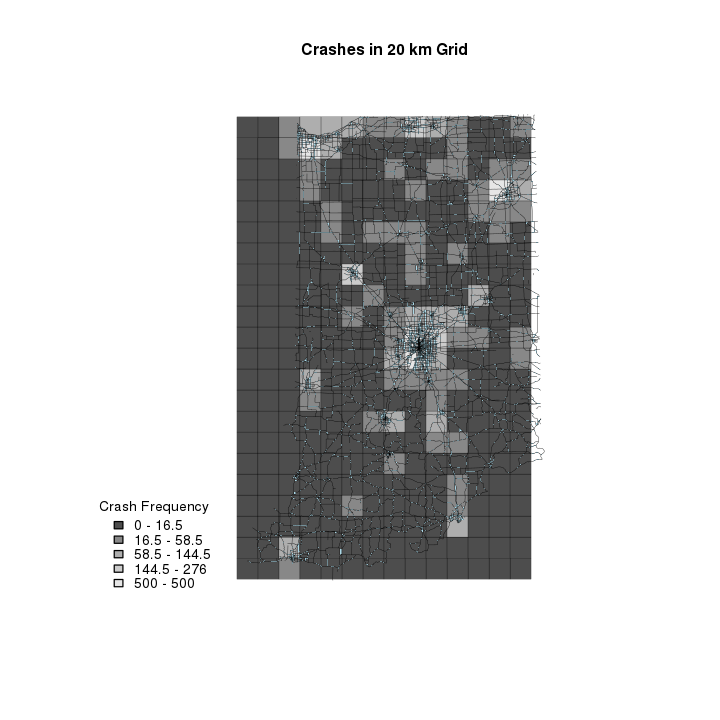

In [20]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf,col=cols,lwd=.2,main="Crashes in 20 km Grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Crash Frequency",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)


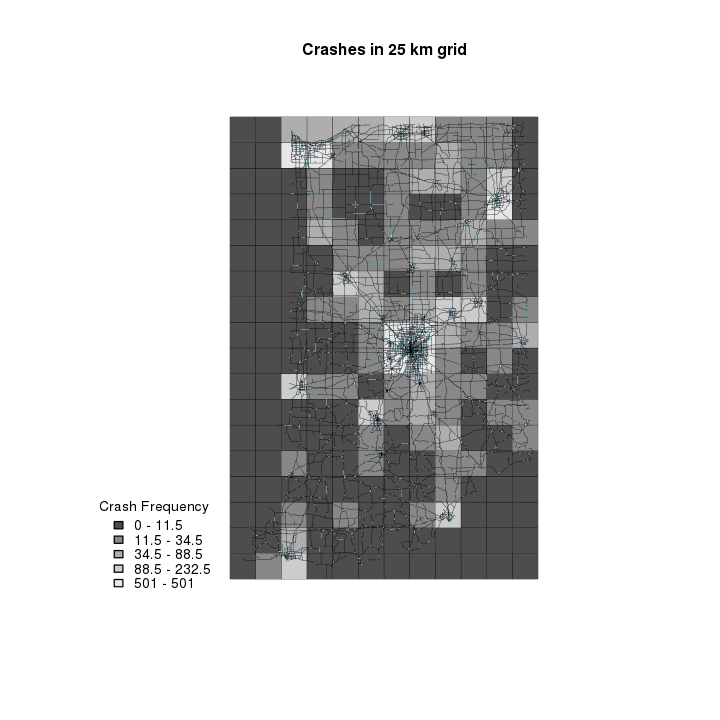

In [21]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf2@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf2,col=cols,lwd=.2,main="Crashes in 25 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Crash Frequency",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)


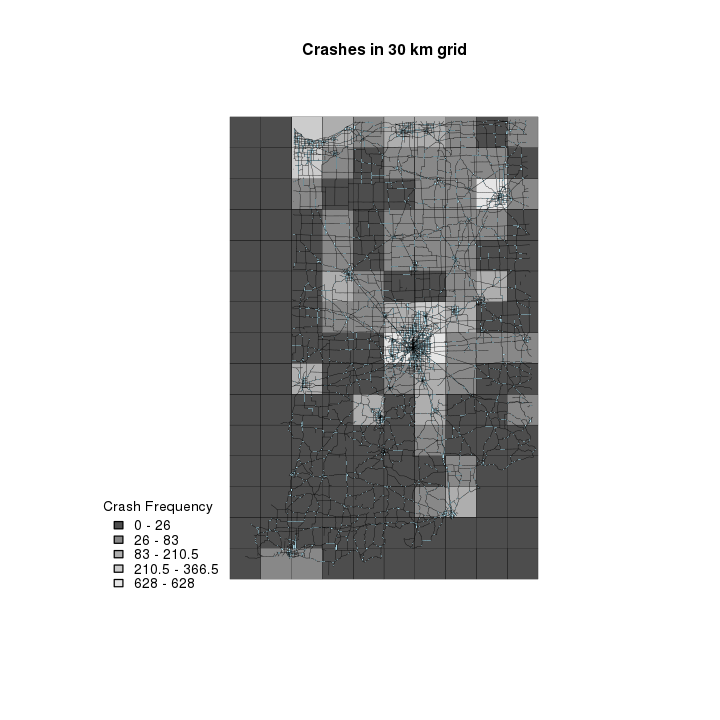

In [22]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf3@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf3,col=cols,lwd=.2,main="Crashes in 30 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Crash Frequency",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)


Now let's compute the total miles of road features within each analysis area and store the total length in a new column in the polygons datasets.

In [23]:
grid_road <- over(inRoads,spdf) 

#configure new variables  str(spdf3@data$id)
inRoads@data$utrackid <- grid_road$id
#inRoads@data$RoadLength <- 0

head(inRoads@data,n=3)

retainedvariables <- c("LENGTHMETER","utrackid")
polyevents <- inRoads@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf@data$LENGTHMETER <- ordered$LENGTHMETER
    
spdf@data$LENGTHMETER

YEAR_RECOR STATE_CODE BEG_POINT END_POINT F_SYSTEM URBAN_CODE FACILITY_T
0 2012       18         11.311    12.57     5        99999      2         
1 2012       18         20.050    20.25     1        99999      2         
2 2012       18         15.590    16.57     1        41212      2         
  THROUGH_LA AADT   VOLUME_GRO <U+22EF>   CRACK_PCT CRACK_LEN RouteID FrMeasure
0 4            6534 4          <U+22EF> 17        105.472   401       8781.3 
1 4           23878 6          <U+22EF>  0          0.000    21     454954.9 
2 6          105514 9          <U+22EF>  0         74.453    43      57313.5 
  ToMeasure SideOfRoad Length   uniqueid LENGTHMETER utrackid
0  15450.8  L          6669.489 1        2032.1222   131     
1 456004.8  L          1049.908 2         319.8868   305     
2  62575.0  L          5261.480 3        1603.0966   150

[1]  11710.069  32309.959  89411.009  48276.537  65135.318  22045.447
  [7]  48391.569  12072.103      0.000      0.000      0.000      0.000
 [13]      0.000      0.000  11751.243  64022.774 229494.169  95486.558
 [19] 117020.243  90220.282  61788.360  26904.897  55089.280  37782.966
 [25]      0.000      0.000      0.000      0.000   6956.117  71438.087
 [31] 126560.926 161997.566  69577.449 145361.688  92186.499  78747.032
 [37] 103443.924 105899.445 131053.933      0.000      0.000      0.000
 [43]      0.000   7638.175  74465.688 100779.372  50332.829  81338.104
 [49]  44905.309  73322.956  90046.183  58239.481 139934.699  20269.683
 [55]      0.000      0.000      0.000      0.000  74972.595  66898.000
 [61]  90027.514  81688.642  55263.981  69045.762  69203.432  71965.986
 [67] 106427.334  63412.940      0.000      0.000      0.000      0.000
 [73]  21038.730  82055.820  36384.837  37973.420  78107.786 135414.692
 [79]  61282.654  67448.434 124103.376  75063.843  84915.925  48750.770
 [85]      0.000      0.000  18944.565  41223.983 108415.181  59029.347
 [91]  92264.340 137753.862  60318.423  95738.551  84090.419  42885.752
 [97]  71409.162  81897.712      0.000      0.000  51119.342  64764.788
[103]  74623.027  55764.197 162817.125 202735.562  78726.343 137192.172
[109]  86279.555  56815.573 124984.451  79137.069      0.000      0.000
[115]  28699.754 105036.606  78872.708  43822.272  91297.683  80866.200
[121] 101999.008  97299.531  46385.784 118517.433  54598.074 103053.196
[127]      0.000      0.000  17329.360 246723.803 109137.668 104725.342
[133]  65213.604 160614.793 179843.578 193146.340 118295.387  56215.199
[139]  82778.529 109716.637      0.000      0.000  34219.341  84399.827
[145]  83528.526  89649.041  86463.533 319533.454 659413.551 277335.894
[151]  64329.956  82507.967  30314.333 112737.418      0.000      0.000
[157]  35179.142  58699.475  93872.995  80370.838 101084.146 305079.204
[163] 742422.252 399689.745  99584.956 113857.643 136439.774  92431.253
[169]      0.000      0.000  15199.418  88253.531 162687.724 127656.505
[175] 108900.029 230262.947 293184.493 297162.372 233418.501  99846.284
[181]  76897.834  69826.668      0.000      0.000  13034.073 104581.236
[187] 111394.121  49559.973 111786.247 127603.030  91145.460 117412.842
[193] 104339.379 199399.990 115452.123  95182.172      0.000      0.000
[199]  15228.042  60632.838  64808.066 255582.861  99491.485  90301.614
[205] 117735.072  98786.242 103585.948 107248.841 109874.620  50109.941
[211]      0.000      0.000  41750.120 101169.360  85577.578  67080.038
[217]  86560.195  73926.825 167333.956  33580.338 182050.377  95069.137
[223]  97775.218  69504.006      0.000      0.000  15004.401  64675.951
[229]  66184.964  33192.531  95585.468 134402.534 100624.133 119018.173
[235]  89622.855 139654.103 120481.784  87081.163      0.000      0.000
[241]   5728.419 155268.669  98117.394  87877.546  77125.456  70481.685
[247]  54956.781  79959.666 115860.966 127176.514 134786.798  38606.719
[253]      0.000      0.000   4176.886  99588.305  70909.561  82817.005
[259]  63976.607  62070.966  86615.717 107473.915 101329.849 119779.536
[265] 305813.651 207116.067      0.000      0.000   6991.590 125818.060
[271]  62471.618  60769.458  76084.005 144779.274 110942.231 116874.096
[277]  99566.744  86057.798  88066.897 174768.634      0.000      0.000
[283]  58529.519 380241.930 255264.613 104251.369  89251.872  80437.511
[289] 101019.789  88770.504 147923.699  79695.484  80002.334 132711.075
[295]      0.000      0.000  68366.985 156682.407 113336.538 184811.699
[301] 147443.489 155116.991 374864.989 274699.039 156561.311  76108.977
[307] 102994.092 166203.614

In [24]:
grid_road2 <- over(inRoads,spdf2) 

#configure new variables  str(spdf3@data$id)
inRoads@data$utrackid <- grid_road2$id
#inRoads@data$RoadLength <- 0

head(inRoads@data,n=3)

retainedvariables <- c("LENGTHMETER","utrackid")
polyevents <- inRoads@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf2@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf2@data$LENGTHMETER <- ordered$LENGTHMETER

YEAR_RECOR STATE_CODE BEG_POINT END_POINT F_SYSTEM URBAN_CODE FACILITY_T
0 2012       18         11.311    12.57     5        99999      2         
1 2012       18         20.050    20.25     1        99999      2         
2 2012       18         15.590    16.57     1        41212      2         
  THROUGH_LA AADT   VOLUME_GRO <U+22EF>   CRACK_PCT CRACK_LEN RouteID FrMeasure
0 4            6534 4          <U+22EF> 17        105.472   401       8781.3 
1 4           23878 6          <U+22EF>  0          0.000    21     454954.9 
2 6          105514 9          <U+22EF>  0         74.453    43      57313.5 
  ToMeasure SideOfRoad Length   uniqueid LENGTHMETER utrackid
0  15450.8  L          6669.489 1        2032.1222    89     
1 456004.8  L          1049.908 2         319.8868   213     
2  62575.0  L          5261.480 3        1603.0966   104

In [25]:
grid_road3 <- over(inRoads,spdf3) 

#configure new variables  str(spdf3@data$id)
inRoads@data$utrackid <- grid_road3$id
#inRoads@data$RoadLength <- 0

head(inRoads@data,n=3)

retainedvariables <- c("LENGTHMETER","utrackid")
polyevents <- inRoads@data[retainedvariables]

polyevents[] <- lapply(polyevents, function(x) type.convert(as.character(x)))

#aggregate data
aggregateevents <- aggregate(polyevents, by=list(polyevents$utrackid),FUN=sum)

#merge aggregate data to grid polygons
gridpols <- merge(spdf3@data, aggregateevents, by.x = "id",by.y="Group.1",all=TRUE)
    
#sort the merged data so it aligns with the order of the grid polygons.
ordered <- gridpols[order(gridpols$id),]

ordered[is.na(ordered)] <- 0

#compute new variables
spdf3@data$LENGTHMETER <- ordered$LENGTHMETER
spdf3@data$LENGTHMETER

YEAR_RECOR STATE_CODE BEG_POINT END_POINT F_SYSTEM URBAN_CODE FACILITY_T
0 2012       18         11.311    12.57     5        99999      2         
1 2012       18         20.050    20.25     1        99999      2         
2 2012       18         15.590    16.57     1        41212      2         
  THROUGH_LA AADT   VOLUME_GRO <U+22EF>   CRACK_PCT CRACK_LEN RouteID FrMeasure
0 4            6534 4          <U+22EF> 17        105.472   401       8781.3 
1 4           23878 6          <U+22EF>  0          0.000    21     454954.9 
2 6          105514 9          <U+22EF>  0         74.453    43      57313.5 
  ToMeasure SideOfRoad Length   uniqueid LENGTHMETER utrackid
0  15450.8  L          6669.489 1        2032.1222    64     
1 456004.8  L          1049.908 2         319.8868   148     
2  62575.0  L          5261.480 3        1603.0966    77

[1]   28054.023  169664.275  158770.411  134718.154   83252.038       0.000
  [7]       0.000       0.000       0.000       0.000   66461.252  237584.005
 [13]  236373.065  235396.725  195003.438  155240.876  166340.277   17947.121
 [19]       0.000       0.000       0.000  106849.615  206828.066  158923.220
 [25]  111135.775  168409.827  213586.124  242897.776    6341.972       0.000
 [31]       0.000   15790.251  214772.894  147229.560  150496.352  140589.179
 [37]  174149.250  209336.227   86442.375   41035.375       0.000   19178.418
 [43]  129953.231  174054.819  236336.070  184379.020  234955.726  151418.349
 [49]  170111.067  162541.517       0.000   24267.628  177239.256  161540.066
 [55]  375535.808  215730.944  248492.675  171258.670  177627.488  166763.591
 [61]       0.000       0.000  369345.705  186877.982  180177.828  480897.793
 [67]  371713.028  222854.638  167108.359  148679.527       0.000       0.000
 [73]  221555.386  174342.844  222107.790 1213331.756  909900.350  208906.888
 [79]  159590.152  251801.241       0.000       0.000  240864.281  254823.702
 [85]  301954.312  576163.209  594038.540  340176.445  234872.226  105250.658
 [91]       0.000       0.000  144338.323  324046.745  252421.912  155016.815
 [97]  266050.265  238929.835  278903.565  103453.879       0.000       0.000
[103]  232347.194  184661.775  156139.681  234658.109  207078.955  302273.712
[109]  206047.975  104294.315       0.000       0.000  178958.734  157756.645
[115]  238524.584  261492.787  230536.626  270307.647  230622.857  102504.159
[121]       0.000       0.000  228922.270  146014.020  146289.699  213582.725
[127]  268550.683  284437.793  562979.488  170050.196       0.000       0.000
[133]  446827.355  236669.949  206293.483  230399.928  203585.012  241245.520
[139]  230181.114  145796.408       0.000       0.000  443204.346  311685.017
[145]  290746.352  454067.781  406026.619  222488.601  189564.716  188108.955

Let's visualize the total length of roads in each analysis polygon. 

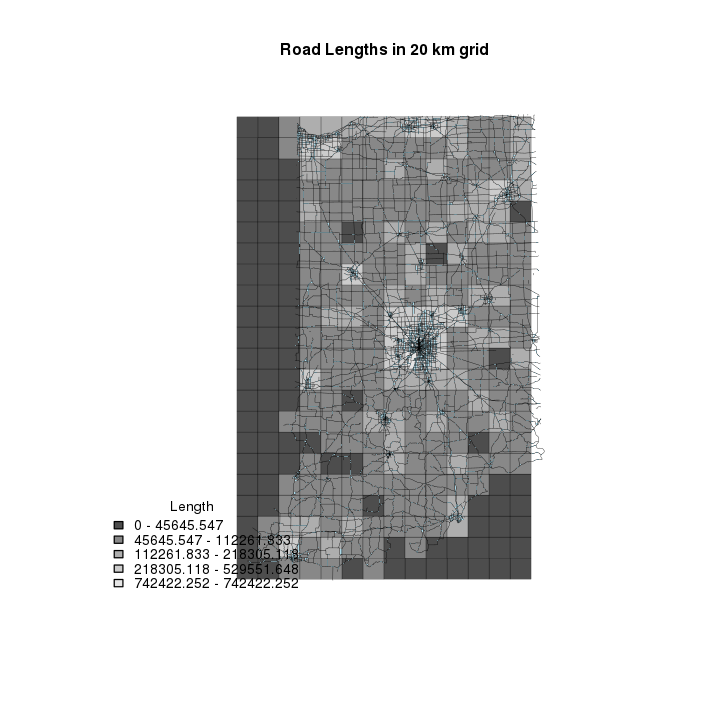

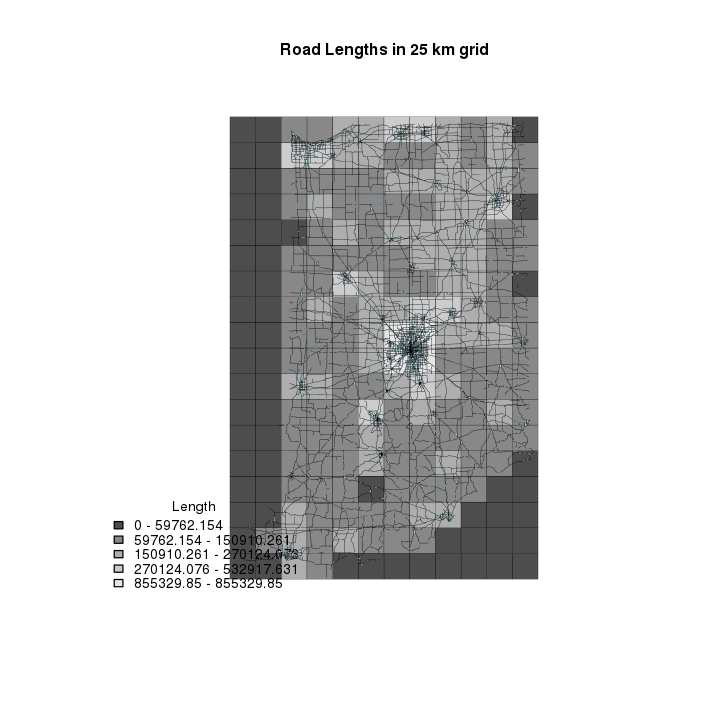

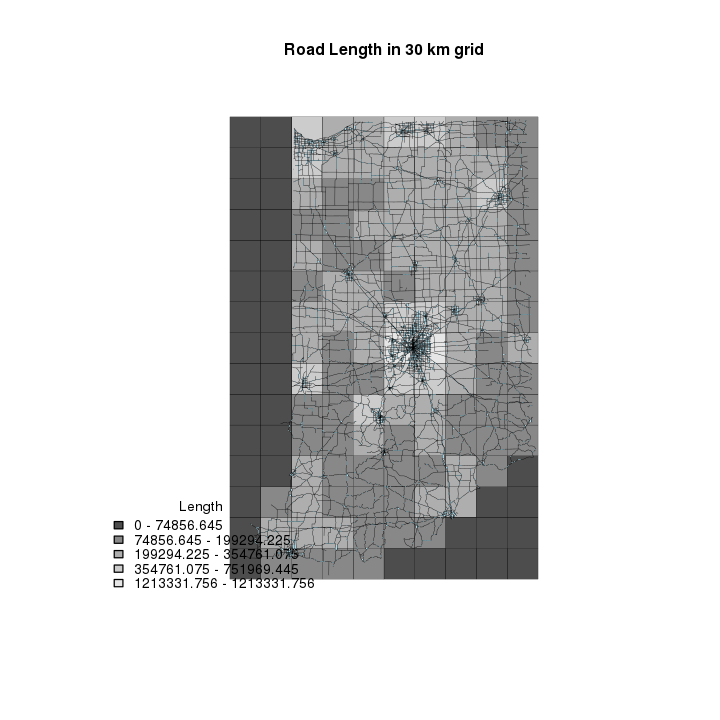

In [26]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf@data$LENGTHMETER, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf,col=cols,lwd=.2,main="Road Lengths in 20 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length ",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

#classify the variable
numcat <- 5
cate <- classIntervals(spdf2@data$LENGTHMETER, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf2,col=cols,lwd=.2,main="Road Lengths in 25 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)


#classify the variable
numcat <- 5
cate <- classIntervals(spdf3@data$LENGTHMETER, numcat, style="kmeans")

#plot the variable
pal1 <- gray.colors(numcat)
cols <- findColours(cate,pal1)
plot(spdf3,col=cols,lwd=.2,main="Road Length in 30 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)


## Spatially Adjusted Regression 

Crashes by Roadway Length 

References: 
https://safety.fhwa.dot.gov/local_rural/training/fhwasaxx1210/s3.cfm

In [27]:
#Identify the neighbors of each feature
spdf.nb <- poly2nb(spdf ,queen=TRUE)

#Retrieve neighborhood list
spdf.listb <- nb2listw(spdf.nb,style="B")
spdf.listw <- nb2listw(spdf.nb,style="W")

In [28]:
str(spdf@data)

#crashes in grid
Y.Var <- spdf$NumCrashes
X.Var <- spdf$LENGTHMETER/1000 # convert to KM

# we might use this info later. 
crash_by_km <- Y.Var/X.Var
#crash_by_km[is.na(crash_by_km,)] 
crash_by_km[0:40]
spdf@data$crash_by_km <- crash_by_km
spdf@data$crash_by_km[is.na(spdf@data$crash_by_km)] <- 0 
summary(spdf@data$crash_by_km)

'data.frame':	308 obs. of  3 variables:
 $ id         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ NumCrashes : num  2 6 43 7 5 1 4 0 0 0 ...
 $ LENGTHMETER: num  11710 32310 89411 48277 65135 ...


[1] 0.17079319 0.18570126 0.48092512 0.14499797 0.07676327 0.04536084
 [7] 0.08265903 0.00000000        NaN        NaN        NaN        NaN
[13]        NaN        NaN 0.00000000 0.06247777 0.48802983 0.12567214
[19] 0.01709106 0.03325195 0.03236856 0.00000000 0.01815235 0.05293391
[25]        NaN        NaN        NaN        NaN 0.00000000 0.06999068
[31] 0.10271733 0.04321053 0.07186236 0.07567331 0.06508545 0.08889224
[37] 0.11600488 0.14164380 0.85460999        NaN

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01010 0.06912 0.12223 0.16023 1.02023 

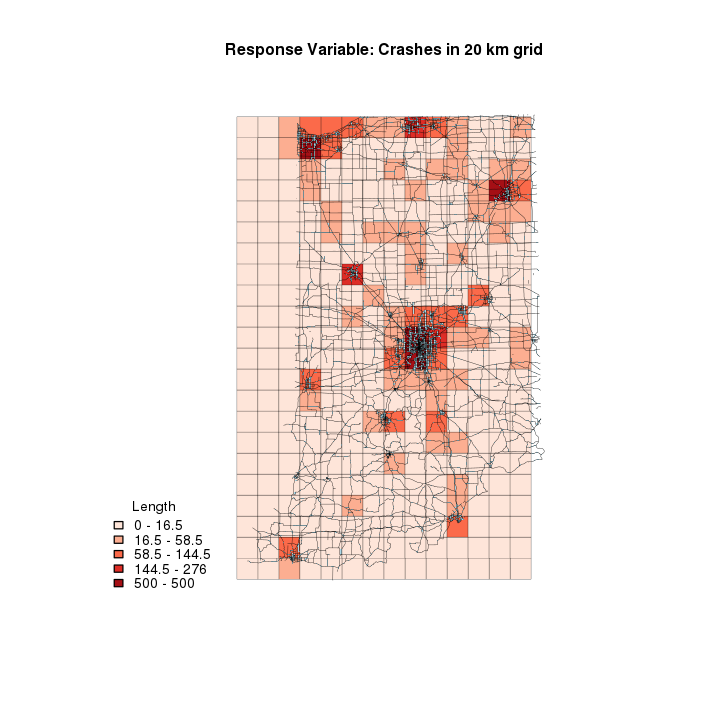

In [29]:
# view the response variable 
#classify the variable
numcat <- 5
cate <- classIntervals(spdf@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)
plot(spdf,col=cols,lwd=.2,main="Response Variable: Crashes in 20 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

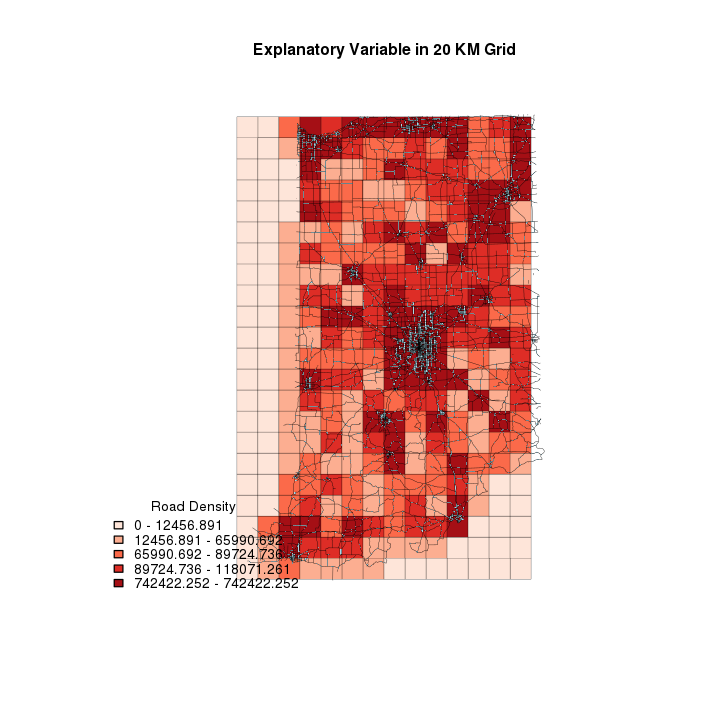

In [30]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf$LENGTHMETER, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(spdf, col=cols, lwd=.2,main="Explanatory Variable in 20 KM Grid",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Road Density",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

## Check Test Statistics for Autocorrelation

Here we run the moran and geary test and notice that spatial autocorrelation exists within this response variable over the region of interest.  

From the results, it looks like the p-value is pretty low so we reject the null hypothesis. This means that the data distribution shows signs of autocorrelation. 

In [31]:
#run autocorrelation tests
moran.test(Y.Var, spdf.listb)
geary.test(Y.Var, spdf.listb)


	Moran I test under randomisation

data:  Y.Var  
weights: spdf.listb  

Moran I statistic standard deviate = 10.867, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.2949404739     -0.0032573290      0.0007529889 



	Geary C test under randomisation

data:  Y.Var 
weights: spdf.listb 

Geary C statistic standard deviate = 3.2877, p-value = 0.000505
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.764647585       1.000000000       0.005124446 


In [32]:
#Conduct a two-group discriminant function analysis using a binary response variable using linear regression specification
YVar.lm <- lm(Y.Var ~ X.Var, data=spdf)
summary(YVar.lm)


Call:
lm(formula = Y.Var ~ X.Var, data = spdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.414 -16.562  -4.601  17.946 179.208 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.63280    2.22788  -11.06   <2e-16 ***
X.Var         0.51477    0.01826   28.19   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 27.54 on 306 degrees of freedom
Multiple R-squared:  0.7219,	Adjusted R-squared:  0.721 
F-statistic: 794.4 on 1 and 306 DF,  p-value: < 2.2e-16


#### Evaluate Autocorrelation of OLS Residuals
Retrieve the residuals from the OLS model. 

Then apply a Moran test for spatial autocorrelation in the residuals.

Note the test is highly significant, indicating the null hypothesis can be rejected. Thus, it is clear that the residuals contain a high level of spatial autocorrelation.

In [33]:
#retrieve residuals from OLS model
YVar.lm.res <- residuals(YVar.lm)

#conduct Moran test
moran.test(YVar.lm.res, spdf.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: spdf.listb  

Moran I statistic standard deviate = 7.4917, p-value = 3.4e-14
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.2128860057     -0.0032573290      0.0008323883 


## Apply a Spatial Simultaneous Autoregressive model on 20 KM Grid

Specify a SAR model. 
Note the differences in the results. Here, the standard errors in the SAR specification differ from those in the OLS model. Also, the rho (lambda) parameter of the SAR model is positive and highly significant. This is evidence that the dependent variable may be afflicted by a high level of spatial autocorrelation. 

In [34]:
#conduct a SAR specification using a binary response variable
YVar.sar <- errorsarlm(Y.Var ~ X.Var,listw=spdf.listw)
summary(YVar.sar)


Call:errorsarlm(formula = Y.Var ~ X.Var, listw = spdf.listw)

Residuals:
     Min       1Q   Median       3Q      Max 
-89.4777 -12.7886   1.8259  12.2507 160.7919 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept) -34.388384   4.415964 -7.7873 6.883e-15
X.Var         0.628100   0.022533 27.8750 < 2.2e-16

Lambda: 0.65552, LR test value: 58.619, p-value: 1.9096e-14
Asymptotic standard error: 0.06046
    z-value: 10.842, p-value: < 2.22e-16
Wald statistic: 117.55, p-value: < 2.22e-16

Log likelihood: -1427.914 for error model
ML residual variance (sigma squared): 575.02, (sigma: 23.98)
Number of observations: 308 
Number of parameters estimated: 4 
AIC: 2863.8, (AIC for lm: 2920.4)


In [35]:
#retrieve residuals from SAR model
YVar.sar.res <- residuals(YVar.sar)

#conduct Moran test
moran.test(YVar.sar.res, spdf.listb)

# notes.  Remember the moran statistic is interpreted as below.  We have a 0.04 moran i stat below which is close to zero
# therefore it is near random and thus autocorrelation appears not to exist. 

#  -1 is perfect clustering of dissimilar values (you can also think of this as perfect dispersion).
#  0 is no autocorrelation (perfect randomness.)
#  +1 indicates perfect clustering of similar values (it’s the opposite of dispersion).


	Moran I test under randomisation

data:  YVar.sar.res  
weights: spdf.listb  

Moran I statistic standard deviate = -1.5023, p-value = 0.9335
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.046719659      -0.003257329       0.000836952 


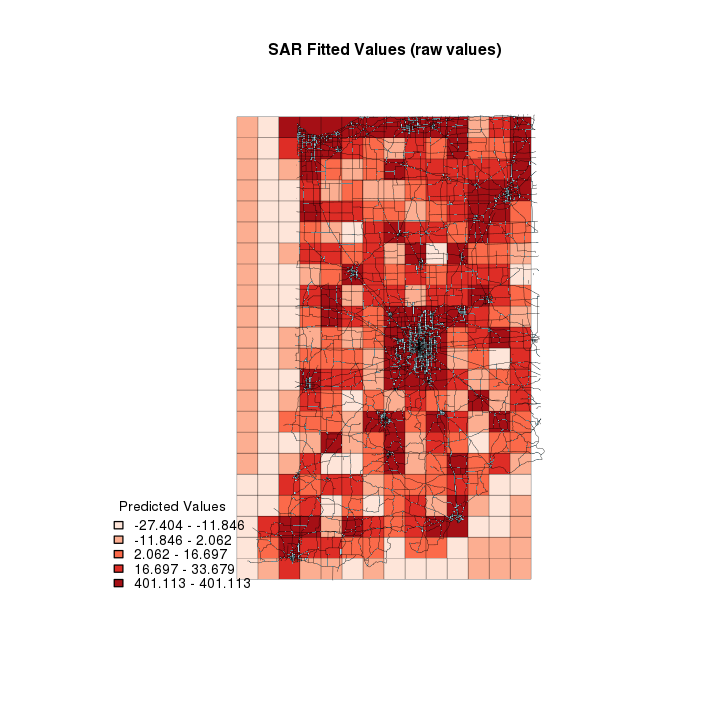

In [36]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sar$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot the variable
plot(spdf, col=cols, lwd=.2,main="SAR Fitted Values (raw values)",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

### **Task 14:** Dataset 2 Analysis


In [37]:
#Identify the neighbors of each feature
spdf2.nb <- poly2nb(spdf2 ,queen=TRUE)

#Retrieve neighborhood list
spdf2.listb <- nb2listw(spdf2.nb,style="B")
spdf2.listw <- nb2listw(spdf2.nb,style="W")


In [38]:
str(spdf2@data)

#crashes in grid
Y.Var <- spdf2$NumCrashes
X.Var <- spdf2$LENGTHMETER/1000 # convert to KM

# we might use this info later. 
crash_by_km <- Y.Var/X.Var
#crash_by_km[is.na(crash_by_km,)] 
crash_by_km[0:40]
spdf2@data$crash_by_km <- crash_by_km
spdf2@data$crash_by_km[is.na(spdf2@data$crash_by_km)] <- 0 
summary(spdf2@data$crash_by_km)

'data.frame':	216 obs. of  3 variables:
 $ id         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ NumCrashes : num  3 15 119 6 7 0 0 0 0 0 ...
 $ LENGTHMETER: num  24086 51553 187648 72677 47586 ...


[1] 0.124554398 0.290960285 0.634167619 0.082556644 0.147102452 0.000000000
 [7]         NaN         NaN         NaN         NaN         NaN         NaN
[13] 0.041762907 0.059743142 0.191870243 0.060192078 0.032873517 0.020256653
[19] 0.000000000 0.062198219 0.518048621         NaN         NaN         NaN
[25]         NaN 0.056296249 0.094871835 0.009708391 0.204365132 0.063779410
[31] 0.061425011 0.138112516 0.679709767         NaN         NaN         NaN
[37]         NaN         NaN 0.029690655 0.048969905

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01808 0.07440 0.12505 0.15941 0.78322 

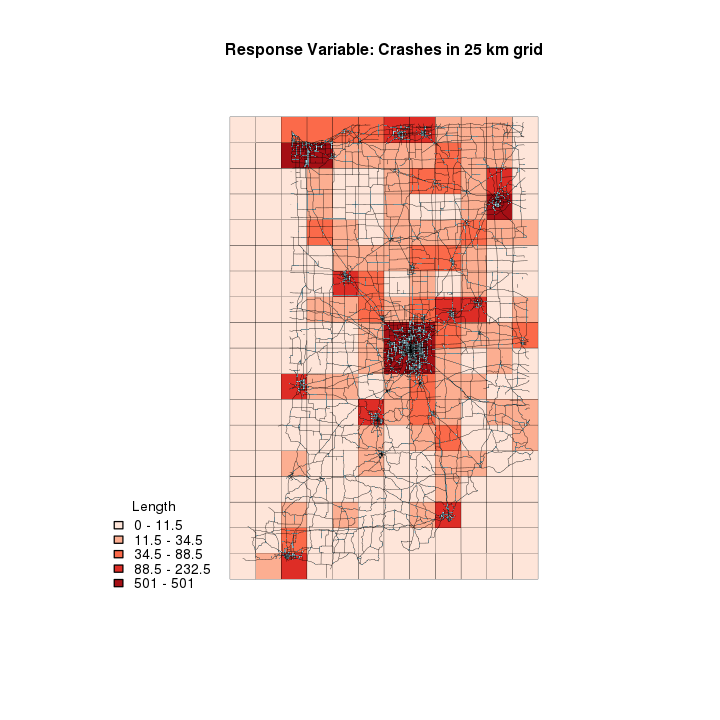

In [39]:
# view the response variable 
#classify the variable
numcat <- 5
cate <- classIntervals(spdf2@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)
plot(spdf2,col=cols,lwd=.2,main="Response Variable: Crashes in 25 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

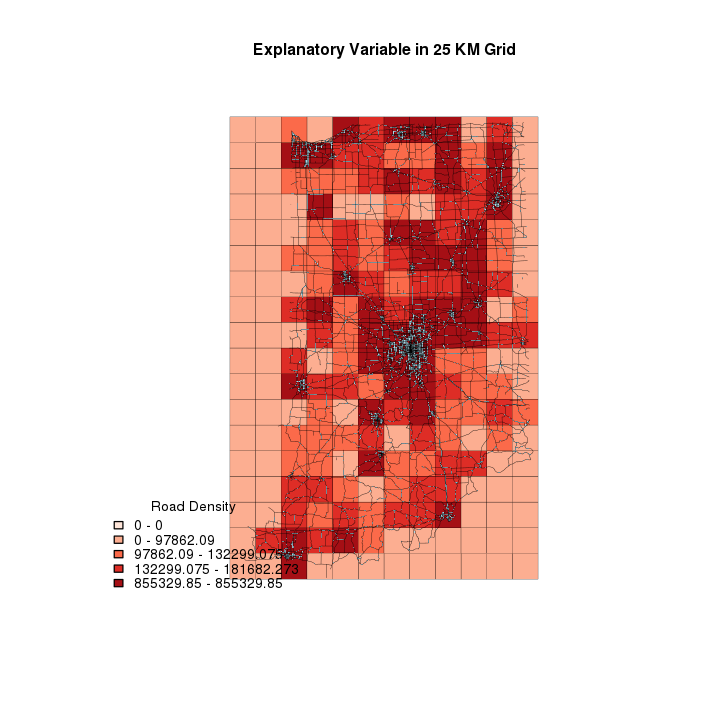

In [40]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf2$LENGTHMETER, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(spdf2, col=cols, lwd=.2,main="Explanatory Variable in 25 KM Grid",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Road Density",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

## Test Statistics for Autocorrelation on 25 KM Grid

Here we run the moran and geary test and notice that spatial autocorrelation exists within this response variable over the region of interest.  

From the results, it looks like the p-value is pretty low so we reject the null hypothesis. This means that the data distribution shows signs of autocorrelation. 

In [41]:
#run autocorrelation tests
moran.test(Y.Var, spdf2.listb)
geary.test(Y.Var, spdf2.listb)


	Moran I test under randomisation

data:  Y.Var  
weights: spdf2.listb  

Moran I statistic standard deviate = 8.1745, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.267456245      -0.004651163       0.001108043 



	Geary C test under randomisation

data:  Y.Var 
weights: spdf2.listb 

Geary C statistic standard deviate = 2.5444, p-value = 0.005473
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.810629657       1.000000000       0.005539083 


In [42]:
#Conduct a two-group discriminant function analysis using a binary response variable using linear regression specification
YVar.lm <- lm(Y.Var ~ X.Var, data=spdf2)
summary(YVar.lm)


Call:
lm(formula = Y.Var ~ X.Var, data = spdf2)

Residuals:
    Min      1Q  Median      3Q     Max 
-77.533 -20.734  -7.033  29.429 174.424 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -31.38404    3.21079  -9.775   <2e-16 ***
X.Var         0.48043    0.01833  26.217   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 32.9 on 214 degrees of freedom
Multiple R-squared:  0.7626,	Adjusted R-squared:  0.7615 
F-statistic: 687.3 on 1 and 214 DF,  p-value: < 2.2e-16


#### Evaluate Autocorrelation of OLS Residuals
Retrieve the residuals from the OLS model. 

Then apply a Moran test for spatial autocorrelation in the residuals.

Note the test is highly significant, indicating the null hypothesis can be rejected. Thus, it is clear that the residuals contain a high level of spatial autocorrelation.

In [43]:
#retrieve residuals from OLS model
YVar.lm.res <- residuals(YVar.lm)

#conduct Moran test
moran.test(YVar.lm.res, spdf2.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: spdf2.listb  

Moran I statistic standard deviate = 8.0198, p-value = 5.297e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.274784685      -0.004651163       0.001214061 


## Apply a Spatial Simultaneous Autoregressive model on 25 KM Grid

Specify a SAR model. 
Note the differences in the results of the two models. Here, the standard errors in the SAR specification differ from those in the OLS model. Also, the rho (lambda) parameter of the SAR model is positive and highly significant. This is evidence that the dependent variable may be afflicted by a high level of spatial autocorrelation. 

In [44]:
#conduct a SAR specification using a binary response variable
YVar.sar <- errorsarlm(Y.Var ~ X.Var,listw=spdf2.listw)
summary(YVar.sar)


Call:errorsarlm(formula = Y.Var ~ X.Var, listw = spdf2.listw)

Residuals:
    Min      1Q  Median      3Q     Max 
-86.246 -17.206   1.449  14.133 140.761 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept) -42.418192   6.994185 -6.0648 1.321e-09
X.Var         0.584373   0.020327 28.7484 < 2.2e-16

Lambda: 0.72006, LR test value: 61.198, p-value: 5.107e-15
Asymptotic standard error: 0.062337
    z-value: 11.551, p-value: < 2.22e-16
Wald statistic: 133.43, p-value: < 2.22e-16

Log likelihood: -1029.5 for error model
ML residual variance (sigma squared): 728.25, (sigma: 26.986)
Number of observations: 216 
Number of parameters estimated: 4 
AIC: 2067, (AIC for lm: 2126.2)


In [45]:
#retrieve residuals from SAR model
YVar.sar.res <- residuals(YVar.sar)

#conduct Moran test
moran.test(YVar.sar.res, spdf2.listb)

# notes.  Remember the moran statistic is interpreted as below.  We have a 0.04 moran i stat below which is close to zero
# therefore it is near random and thus autocorrelation appears not to exist. 

#  -1 is perfect clustering of dissimilar values (you can also think of this as perfect dispersion).
#  0 is no autocorrelation (perfect randomness.)
#  +1 indicates perfect clustering of similar values (it’s the opposite of dispersion).


	Moran I test under randomisation

data:  YVar.sar.res  
weights: spdf2.listb  

Moran I statistic standard deviate = -0.79712, p-value = 0.7873
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.032493193      -0.004651163       0.001219987 


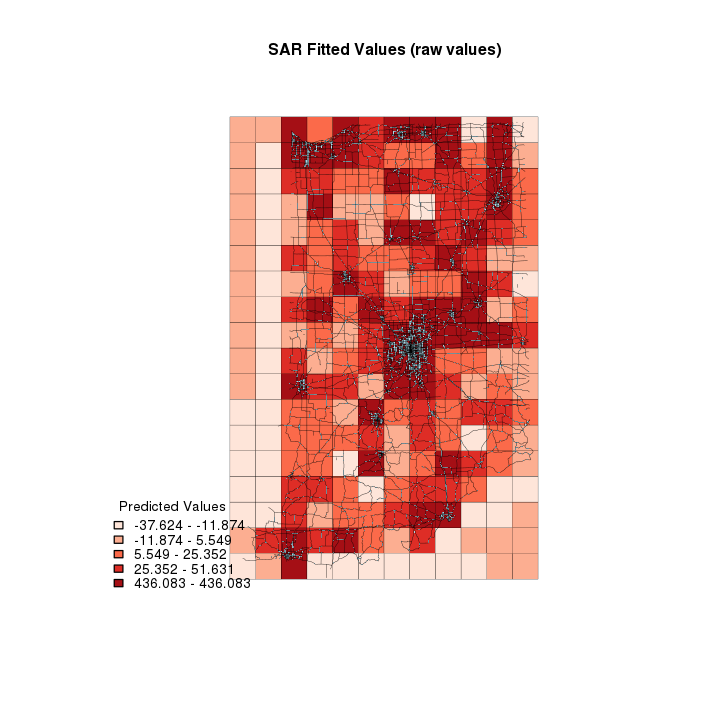

In [46]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sar$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot the variable
plot(spdf2, col=cols, lwd=.2,main="SAR Fitted Values (raw values)",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

Now let's check out the third level of analysis polygons

In [47]:
#Identify the neighbors of each feature
spdf3.nb <- poly2nb(spdf3 ,queen=TRUE)

#Retrieve neighborhood list
spdf3.listb <- nb2listw(spdf3.nb,style="B")
spdf3.listw <- nb2listw(spdf3.nb,style="W")


In [48]:
str(spdf3@data)

#crashes in grid
Y.Var <- spdf3$NumCrashes
X.Var <- spdf3$LENGTHMETER/1000 # convert to KM

# we might use this info later. 
crash_by_km <- Y.Var/X.Var
#crash_by_km[is.na(crash_by_km,)] 
crash_by_km[0:40]
spdf3@data$crash_by_km <- crash_by_km
spdf3@data$crash_by_km[is.na(spdf3@data$crash_by_km)] <- 0 
summary(spdf3@data$crash_by_km)

'data.frame':	150 obs. of  3 variables:
 $ id         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ NumCrashes : num  6 75 76 6 6 0 0 0 0 0 ...
 $ LENGTHMETER: num  28054 169664 158770 134718 83252 ...


[1] 0.21387307 0.44204945 0.47867861 0.04453743 0.07207031        NaN
 [7]        NaN        NaN        NaN        NaN 0.10532453 0.08838979
[13] 0.08884261 0.04248147 0.05128115 0.03220801 0.12023546 0.94722716
[19]        NaN        NaN        NaN 0.08423053 0.05318427 0.15101632
[25] 0.04499001 0.04156527 0.22473370 0.53108761 0.00000000        NaN
[31]        NaN 0.06333022 0.09777770 0.05433691 0.03986808 0.07824215
[37] 0.04593761 0.13853312 0.15038920 0.02436922

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.03279 0.08886 0.13820 0.18206 0.94723 

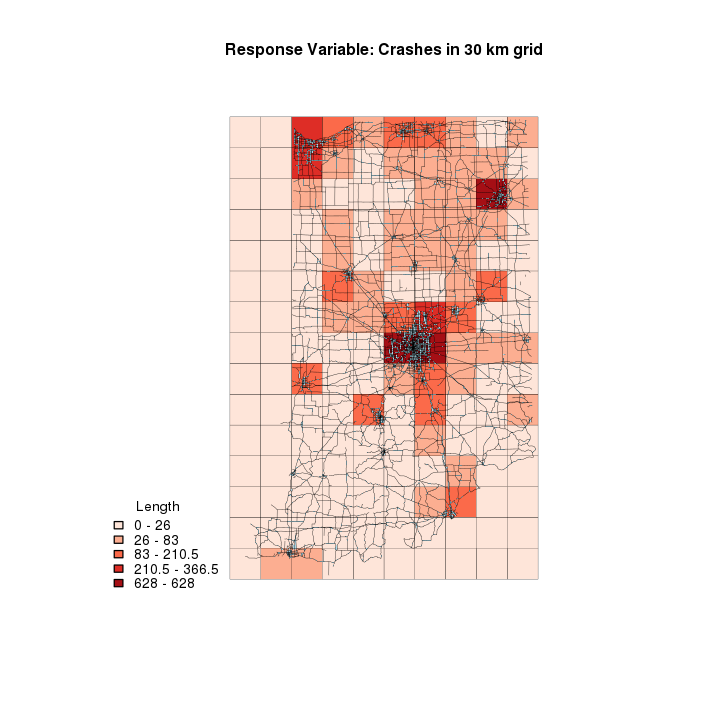

In [49]:
# view the response variable 
#classify the variable
numcat <- 5
cate <- classIntervals(spdf3@data$NumCrashes, numcat, style="kmeans")

#plot the variable
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)
plot(spdf3,col=cols,lwd=.2,main="Response Variable: Crashes in 30 km grid",cex.main=.8)
brks <- round(cate$brks,3)
leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Length",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

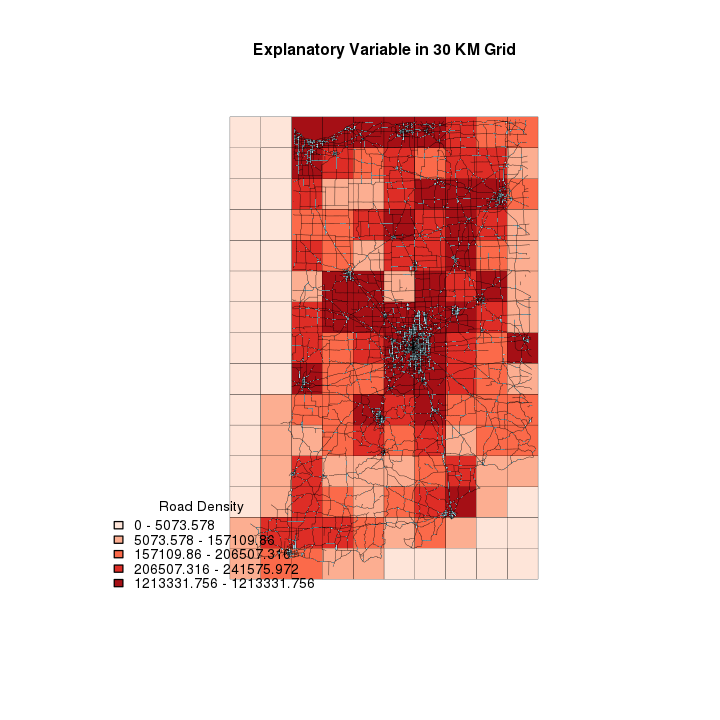

In [50]:
#classify the variable
numcat <- 5
cate <- classIntervals(spdf3$LENGTHMETER, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(spdf3, col=cols, lwd=.2,main="Explanatory Variable in 30 KM Grid",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Road Density",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

## Examine Test Statistics for Autocorrelation on 30 KM Grid

Here we run the moran and geary test and notice that spatial autocorrelation exists within this response variable over the region of interest.  

From the results, it looks like the p-value is pretty low so we reject the null hypothesis. This means that the data distribution shows signs of autocorrelation. 

In [51]:
#run autocorrelation tests
moran.test(Y.Var, spdf3.listb)
geary.test(Y.Var, spdf3.listb)


	Moran I test under randomisation

data:  Y.Var  
weights: spdf3.listb  

Moran I statistic standard deviate = 6.4463, p-value = 5.73e-11
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.245310633      -0.006711409       0.001528459 



	Geary C test under randomisation

data:  Y.Var 
weights: spdf3.listb 

Geary C statistic standard deviate = 1.8914, p-value = 0.02929
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.821626505       1.000000000       0.008894382 


In [52]:
#Conduct a two-group discriminant function analysis using a binary response variable using linear regression specification
YVar.lm <- lm(Y.Var ~ X.Var, data=spdf3)
summary(YVar.lm)


Call:
lm(formula = Y.Var ~ X.Var, data = spdf3)

Residuals:
   Min     1Q Median     3Q    Max 
-97.68 -29.08 -12.28  39.06 219.67 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -39.06417    5.23964  -7.456 6.96e-12 ***
X.Var         0.44655    0.02147  20.800  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 43.09 on 148 degrees of freedom
Multiple R-squared:  0.7451,	Adjusted R-squared:  0.7434 
F-statistic: 432.6 on 1 and 148 DF,  p-value: < 2.2e-16


#### Evaluate Autocorrelation of OLS Residuals
Retrieve the residuals from the OLS model. 

Then apply a Moran test for spatial autocorrelation in the residuals.

Note the test is highly significant, indicating the null hypothesis can be rejected. Thus, it is clear that the residuals contain a high level of spatial autocorrelation.

In [53]:
#retrieve residuals from OLS model
YVar.lm.res <- residuals(YVar.lm)

#conduct Moran test
moran.test(YVar.lm.res, spdf3.listb)


	Moran I test under randomisation

data:  YVar.lm.res  
weights: spdf3.listb  

Moran I statistic standard deviate = 4.8746, p-value = 5.452e-07
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.196947923      -0.006711409       0.001745567 


## Apply a Spatial Simultaneous Autoregressive model on 30 KM Grid

Specify a SAR model. 
Note the differences in the results of the two models. Here, the standard errors in the SAR specification differ from those in the OLS model. Also, the rho (lambda) parameter of the SAR model is positive and highly significant. This is evidence that the dependent variable may be afflicted by a high level of spatial autocorrelation. 

In [54]:
#conduct a SAR specification using a binary response variable
YVar.sar <- errorsarlm(Y.Var ~ X.Var,listw=spdf3.listw)
summary(YVar.sar)


Call:errorsarlm(formula = Y.Var ~ X.Var, listw = spdf3.listw)

Residuals:
        Min          1Q      Median          3Q         Max 
-121.679867  -23.198349   -0.085957   19.669618  195.621417 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept) -55.739705  10.523922 -5.2965 1.181e-07
X.Var         0.554342   0.025402 21.8229 < 2.2e-16

Lambda: 0.68347, LR test value: 30.007, p-value: 4.3057e-08
Asymptotic standard error: 0.079186
    z-value: 8.6312, p-value: < 2.22e-16
Wald statistic: 74.498, p-value: < 2.22e-16

Log likelihood: -761.3318 for error model
ML residual variance (sigma squared): 1366.5, (sigma: 36.966)
Number of observations: 150 
Number of parameters estimated: 4 
AIC: 1530.7, (AIC for lm: 1558.7)


In [55]:
#retrieve residuals from SAR model
YVar.sar.res <- residuals(YVar.sar)

#conduct Moran test
moran.test(YVar.sar.res, spdf3.listb)

# notes.  Remember the moran statistic is interpreted as below.  We have a 0.04 moran i stat below which is close to zero
# therefore it is near random and thus autocorrelation appears not to exist. 

#  -1 is perfect clustering of dissimilar values (you can also think of this as perfect dispersion).
#  0 is no autocorrelation (perfect randomness.)
#  +1 indicates perfect clustering of similar values (it’s the opposite of dispersion).


	Moran I test under randomisation

data:  YVar.sar.res  
weights: spdf3.listb  

Moran I statistic standard deviate = -1.3347, p-value = 0.909
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.062400768      -0.006711409       0.001740975 


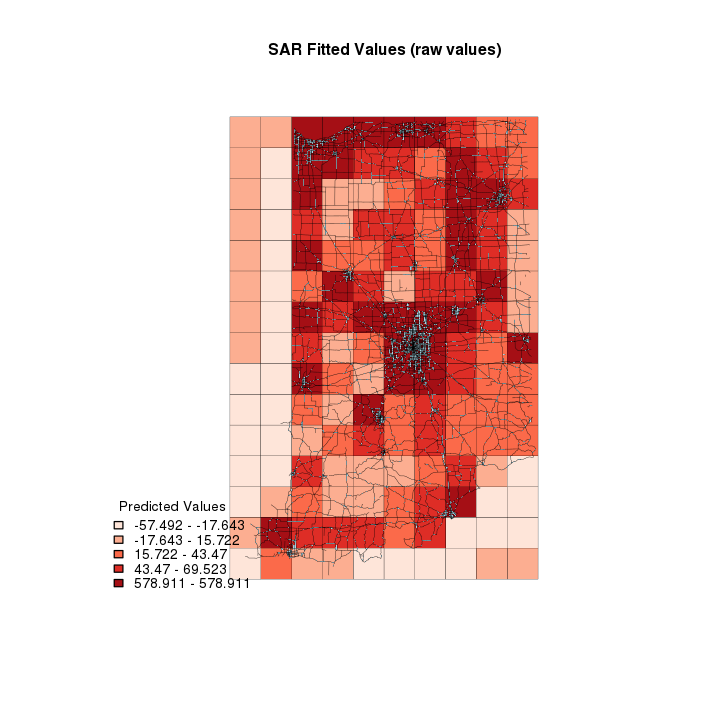

In [56]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sar$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot the variable
plot(spdf3, col=cols, lwd=.2,main="SAR Fitted Values (raw values)",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)

## Compare results using MAUP 

#### Comput the Gi for each of the Grids on crash rates per km

In [57]:
#Compute local Gi* statistic  spdf@data$crash_by_km
Afeat.Gi <- localG(spdf@data$crash_by_km, spdf.listb)

#Compute effective sample size
feat.d.sar <- errorsarlm(spdf@data$crash_by_km ~1, listw=spdf.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(spdf)

#Calculated effective sample size per Griffith's (2005) eq.
ESSA <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSA,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(spdf@data$crash_by_km)
    newpr <- 1-(((1-pr)/ESSA)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

AzcG <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,AzcG,sep="   ")

[1] "ESS = 60.9955259592087"

[1] "0.9   3.2710254068498"   "0.95   3.46827725660486"

In [58]:
#Compute local Gi* statistic
Bfeat.Gi <- localG(spdf2@data$crash_by_km, spdf2.listb)

#Compute effective sample size
feat.d.sar <- errorsarlm(spdf2@data$crash_by_km ~1, listw=spdf2.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(spdf)

#Calculated effective sample size per Griffith's (2005) eq.
ESSB <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSB,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(spdf2@data$crash_by_km)
    newpr <- 1-(((1-pr)/ESSB)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

BzcG <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,BzcG,sep="   ")

[1] "ESS = 67.4793118449902"

[1] "0.9   3.30325023936811" "0.95   3.4990062190605"

In [59]:
#Compute local Gi* statistic  spdf@data$crash_by_km
Afeat.Gi3 <- localG(spdf3@data$crash_by_km, spdf3.listb)

#Compute effective sample size
feat.d.sar <- errorsarlm(spdf3@data$crash_by_km ~1, listw=spdf3.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(spdf3)

#Calculated effective sample size per Griffith's (2005) eq.
ESSA <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSA,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(spdf3@data$crash_by_km)
    newpr <- 1-(((1-pr)/ESSA)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

AzcG3 <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,AzcG3,sep="   ")

[1] "ESS = 46.2849176871353"

[1] "0.9   3.2054287363706"  "0.95   3.4069420388014"

## MAUP / Comparison (Gi*)



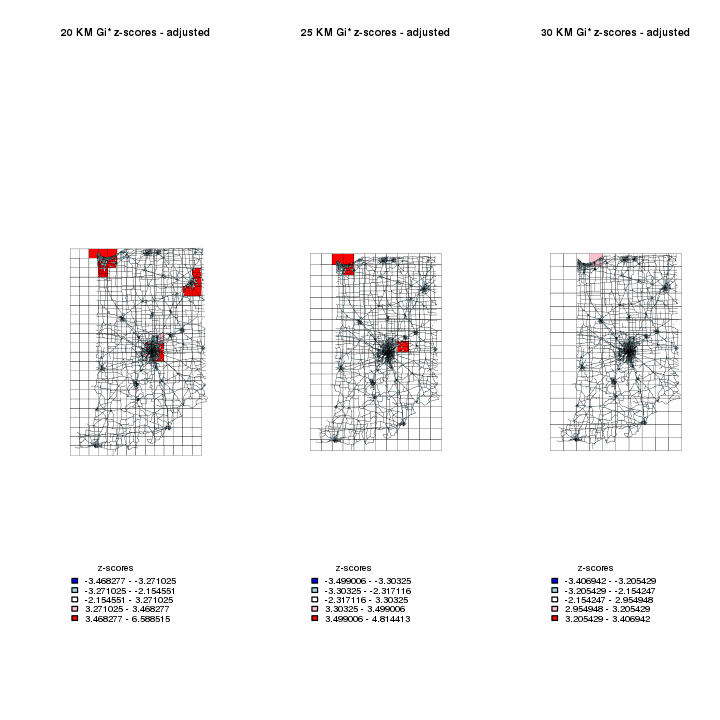

In [60]:
par(mfrow=c(1,3))

#Plot 20 KM code areas
#classify adjusted Gi* z-score significance 
Anczc1 <- 4 + length(AzcG) - 1
Anczc2 <- 4 + length(AzcG)
Az.Gi <- classIntervals(Afeat.Gi,n=Anczc1, style="fixed",fixedBreaks=c(min(Afeat.Gi), -AzcG, AzcG, max(Afeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Az.Gi, pal)
plot(spdf, col=cols.Gi,lwd=.2,main="20 KM Gi* z-scores - adjusted",cex.main=.8)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)
brks <- round(Az.Gi$brks, Anczc2)
leg <- paste(brks[-Anczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

#Plot 25 KM areas
#classify adjusted Gi* z-score significance 
Bnczc1 <- 4 + length(BzcG) - 1
Bnczc2 <- 4 + length(BzcG)
Bz.Gi <- classIntervals(Bfeat.Gi,n=Bnczc1, style="fixed",fixedBreaks=c(min(Bfeat.Gi), -BzcG, BzcG, max(Bfeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Bz.Gi, pal)
plot(spdf2, col=cols.Gi,lwd=.2,main="25 KM Gi* z-scores - adjusted",cex.main=.8)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)
brks <- round(Bz.Gi$brks, Bnczc2)
leg <- paste(brks[-Bnczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

#Plot 30 KM areas
#classify adjusted Gi* z-score significance 
Anczc1 <- 4 + length(AzcG3) - 1
Anczc2 <- 4 + length(AzcG3)
Az.Gi <- classIntervals(Afeat.Gi3,n=Anczc1, style="fixed",fixedBreaks=c(min(Afeat.Gi3), -AzcG3, AzcG3, max(Afeat.Gi3)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Az.Gi, pal)
plot(spdf3, col=cols.Gi,lwd=.2,main="30 KM Gi* z-scores - adjusted",cex.main=.8)
plot(road_union,col="lightblue",lwd=.2,add=TRUE)
brks <- round(Az.Gi$brks, Anczc2)
leg <- paste(brks[-Anczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

## ANALYSIS SUMMARY

#### Spatially Adjusted Regression on 20 KM Grid

#### Spatially Adjusted Regression on 25 KM Grid


#### Spatially Adjusted Regression on 30 KM Grid


### MAUP Comparisson 

So when we compare the results using the Gi Statistic on the different grids we notice how MAUP is playing out on the different
geographies.  The first thing that could have happened is the neighbors might have been reduced so that some polygons 
could have been no longer considered.  Also we notice just minor changes in our Moran statistics.  Overall the changes were
generally minor, but we did see some changes.  Even though there are just minor changes we can see how this really can change the 
crash rate results over different geographies. 
